In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation settings

In [22]:
L = 8
J = 1
h = 0.05
lamb = 0.7

x_basis = False

particle_pair_left_position = L//2 - 1
particle_pair_length = 1

final_time = 8
layers = 25
measure_every_layers = 1

# Device selection

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
device = "ibm_kyiv"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

# Circuit transpilation

Longest circuit has 100 2-qb depth


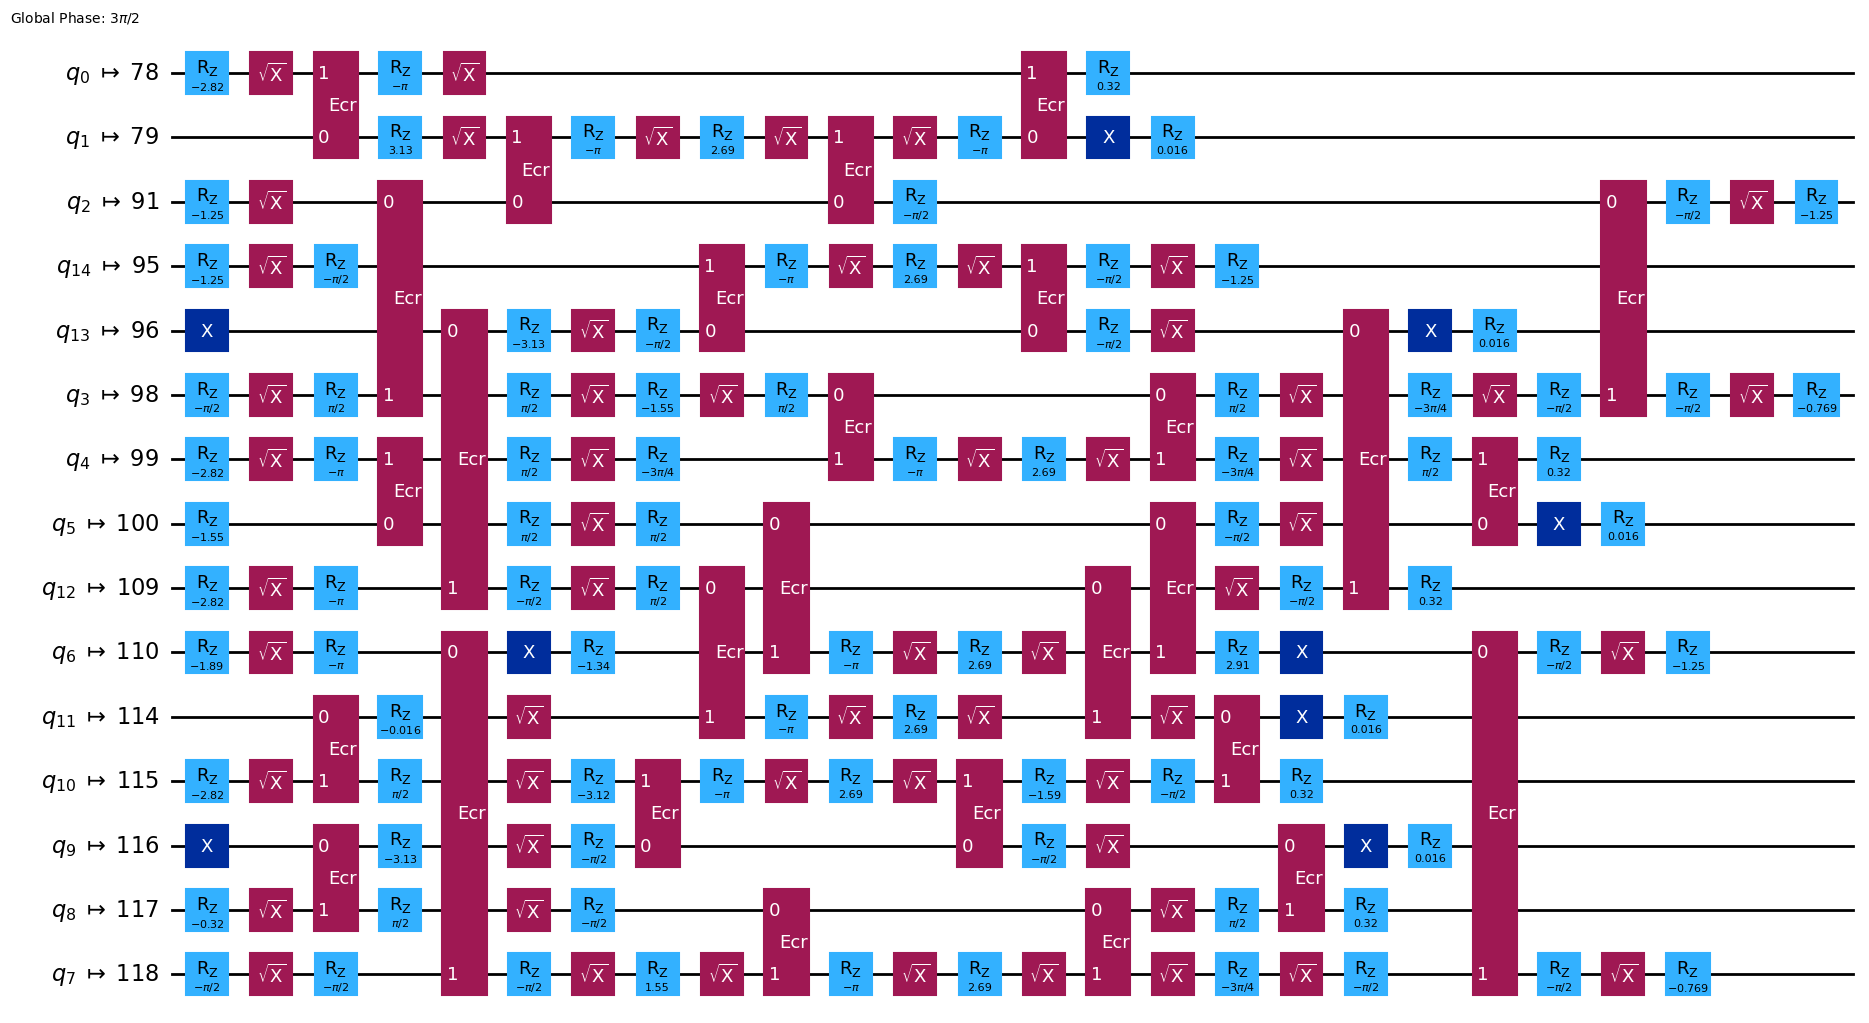

In [24]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

# qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22, 21, 20, 33, 39, 40,
#                41, 42, 43, 44, 45, 54, 64, 63, 62, 72, 
#                81, 82, 83, 92, 102, 103, 104, 111, 122,
#                121, 120, 119, 118, 116, 115, 114, 109, 96, 95]
qubits_inds = backend.properties().general_qlists[0]["qubits"][:2*L-1]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers, x_basis=x_basis)
longest_2qb_depth = physical_circuits[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1)

# Post-selected circuit execution

### Options

In [25]:
from utils.hexec import ExecDB

execution_database = "z2_chain_jobs.json"

sampler_options = {
    "default_shots": 10000,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

job_db = ExecDB(execution_database)

### Observables & postselection

In [26]:
from z2chain.operators import local_pauli_z, local_pauli_x, gauge_operator
from functools import partial

observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
postselect_generating_func = lambda nqubits: [gauge_operator((nqubits + 1)//2, site_ind, x_basis) for site_ind in range((nqubits + 1)//2)]

### Send jobs to hardware

In [ ]:
jobs = job_db.execute_sampler_batch(backend, sampler_options, physical_circuits)

### Load jobs with the same options

In [7]:
from utils.postselection import measure_post_selected_observables

jobs = job_db.search_by_params(sampler_options, physical_circuits, "Sampler", strict_depth=False, limit=1, ibmq_service=service)
jobs

[<RuntimeJobV2('cvcq90mkmd10008pns30', 'sampler')>,
 <RuntimeJobV2('cvcq91wvawwg008921v0', 'sampler')>,
 <RuntimeJobV2('cvcq92mw5350008wypz0', 'sampler')>,
 <RuntimeJobV2('cvcq93mz17rg008d3deg', 'sampler')>,
 <RuntimeJobV2('cvcq94w8w2g0008e9p0g', 'sampler')>,
 <RuntimeJobV2('cvcq96cz17rg008d3df0', 'sampler')>,
 <RuntimeJobV2('cvcq97m8w2g0008e9p10', 'sampler')>,
 <RuntimeJobV2('cvcq98xw5350008wyq00', 'sampler')>,
 <RuntimeJobV2('cvcq9a5kmd10008pns3g', 'sampler')>,
 <RuntimeJobV2('cvcq9bdz17rg008d3dg0', 'sampler')>,
 <RuntimeJobV2('cvcq9cdw5350008wyq0g', 'sampler')>,
 <RuntimeJobV2('cvcq9dnkmd10008pns4g', 'sampler')>,
 <RuntimeJobV2('cvcq9ex8w2g0008e9p2g', 'sampler')>,
 <RuntimeJobV2('cvcq9fxvawwg008921w0', 'sampler')>,
 <RuntimeJobV2('cvcq9gy8w2g0008e9p30', 'sampler')>,
 <RuntimeJobV2('cvcq9hyw5350008wyq10', 'sampler')>,
 <RuntimeJobV2('cvcq9jyz17rg008d3dh0', 'sampler')>,
 <RuntimeJobV2('cvcq9mekmd10008pns50', 'sampler')>,
 <RuntimeJobV2('cvcq9npz17rg008d3dhg', 'sampler')>,
 <RuntimeJob

In [11]:
from z2chain.postselection import measure_post_selected_observables
site_gauge_observable_matrix = measure_post_selected_observables(jobs[1::], observable_generating_funcs, postselect_generating_func)

Commutation check
Computing observables


TypeError: argument 'num_qubits': 'NoneType' object cannot be interpreted as an integer

# Plots

### Quech plot

In [ ]:
from z2chain.plotting import x_t_plot

x_t_plot(jobs, filepath=f"Plots/hardware_postselection_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png")

### Comparison with circuit tensor network simulation

In [ ]:
from z2chain.plotting import x_t_plot, save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.circs import particle_pair_quench_simulation_circuits
from utils.sexec import execute_simulation_estimator_batch
import os

simulator_estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{simulator_estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    tn_site_gauge_observable_matrix = load_site_gauge_observable_matrix(filepath)
else:
    logical_circs = particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)
    observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]
    tn_site_gauge_observable_matrix = execute_simulation_estimator_batch(mps_simulator_options, simulator_estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(tn_site_gauge_observable_matrix, filepath)

x_t_plot(tn_site_gauge_observable_matrix, filepath=os.path.join("Plots", os.path.basename(os.path.split(filepath)[1])) + ".png")

In [ ]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(tn_site_gauge_observable_matrix, jobs, filepath=f"Plots/hardware_discrepancies_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{estimator_options["resilience"]["zne_mitigation"]}_{"-".join([str(i) for i in estimator_options["resilience"]["zne"]["noise_factors"]])}_mm_{estimator_options["resilience"]["measure_mitigation"]}_dc_{estimator_options["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png")